In [ ]:
import inspect
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ConfigSpace import (
    Categorical,
    Configuration,
    ConfigurationSpace,
    Float,
    InCondition,
    Integer,
)
from ConfigSpace.conditions import EqualsCondition, InCondition
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from smac import HyperparameterOptimizationFacade, Scenario

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*algorithm did not converge.*")

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0

PHASE1_DIR = Path(".")
PROCESSED_DIR = PHASE1_DIR / "processed"

In [3]:
evaluations_df = pd.read_parquet(PROCESSED_DIR / "evaluations.parquet")
solvers_df = pd.read_parquet(PROCESSED_DIR / "solvers.parquet")
instances_df = pd.read_parquet(PROCESSED_DIR / "instances.parquet")

df = pd.merge(evaluations_df, solvers_df, left_on="solver_id", right_on="id").drop(columns=["id"])
df = pd.merge(df, instances_df, left_on="instance_id", right_on="id").drop(columns=["id"])
df

,solver_id,instance_id,generator,cost,log_cost,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,...,mst_dists_span,mst_dists_coef_of_var,mst_dists_sum,nnds_min,nnds_median,nnds_mean,nnds_max,nnds_sd,nnds_span,nnds_coef_of_var
0,1251473931473582278,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,4.74,1.747459,0.95,1.0,0.0,0.0,0.2,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
1,2289112522627003788,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,0.02,0.019803,0.15,0.0,1.0,1.0,0.4,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
2,960932965817811220,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,3.72,1.551809,0.20,0.0,1.0,2.0,0.9,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
3,39012066323493184,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,1.52,0.924259,0.60,1.0,1.0,2.0,0.7,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
4,494182449327999052,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,84.44,4.447814,0.90,1.0,1.0,3.0,0.3,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1286196444435323941,TSP/TRAIN/grid/019.tsp,grid,208.32,5.343864,0.45,0.0,0.0,0.0,0.2,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99996,1435531534300921454,TSP/TRAIN/grid/019.tsp,grid,300.00,5.707110,0.20,1.0,0.0,3.0,0.6,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99997,27607668447685341,TSP/TRAIN/grid/019.tsp,grid,3.21,1.437463,0.95,1.0,1.0,3.0,0.9,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99998,2245205590089179674,TSP/TRAIN/grid/019.tsp,grid,17.23,2.903069,0.65,0.0,0.0,1.0,0.5,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201


## Functions

In [4]:
def get_n_splits(df, n, instance_number, solver_number, random_state=0):
    """
    Generate indices to split data into training and test sets.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing solver evaluation data
    n : int
        Number of splits
    instance_number : int
        Number of instances to select
    solver_number : int
        Number of solver configurations to select
    random_state : int, default=0
        Random state for reproducibility
        
    Yields:
    -------
    train_idx : numpy.array
        Indices of training set
    test_idx : numpy.array
        Indices of test set
        
    Notes:
    ------
    1. Randomly selects solver_number solvers and instance_number instances from df
    2. Ensures that all evaluations from one solver are either in train or test set
    """
    rng = np.random.default_rng(random_state)
    
    if solver_number % n != 0:
        raise ValueError(f"solver_number ({solver_number}) must be divisible by n ({n})")
    
    all_solver_ids = df['solver_id'].unique()
    all_instance_ids = df['instance_id'].unique()
    
    if len(all_solver_ids) < solver_number:
        raise ValueError(f"Not enough solvers in df ({len(all_solver_ids)}) to select {solver_number}")
    
    if len(all_instance_ids) < instance_number:
        raise ValueError(f"Not enough instances in df ({len(all_instance_ids)}) to select {instance_number}")
    
    selected_solver_ids = rng.choice(all_solver_ids, size=solver_number, replace=False)
    selected_instance_ids = rng.choice(all_instance_ids, size=instance_number, replace=False)
    
    subset_df = df[
        df['solver_id'].isin(selected_solver_ids) & 
        df['instance_id'].isin(selected_instance_ids)
    ]
    
    expected_rows = solver_number * instance_number
    if len(subset_df) != expected_rows:
        raise ValueError(f"Incomplete data: Found {len(subset_df)} rows instead of expected {expected_rows}")
    
    solvers_per_fold = solver_number // n
    shuffled_solver_ids = rng.permutation(selected_solver_ids)
    
    for i in range(n):
        test_solvers = shuffled_solver_ids[i * solvers_per_fold:(i + 1) * solvers_per_fold]
        
        test_idx = subset_df[subset_df['solver_id'].isin(test_solvers)].index.values
        train_idx = subset_df[~subset_df['solver_id'].isin(test_solvers)].index.values
        
        total_samples = len(train_idx) + len(test_idx)
        if total_samples != expected_rows:
            raise ValueError(f"Total samples ({total_samples}) doesn't match expected number ({expected_rows})")
        
        yield train_idx, test_idx

In [143]:
def evaluate_model_with_cross_validation(
    df, 
    model, 
    n=5, 
    instance_number=10, 
    solver_number=1000, 
    random_state=0,
):
    """
    Evaluate a model using n-fold cross-validation, recording performance metrics.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing solver evaluation data
    model : estimator object
        The model to be trained and evaluated
    n : int, default=5
        Number of splits
    instance_number : int, default=10
        Number of instances to select
    solver_number : int, default=1000
        Number of solver configurations to select
    random_state : int, default=0
        Random state for reproducibility

    Returns:
    --------
    dict
        Dictionary with keys:
        - 'model': the model name or object
        - 'rmse': average root mean squared error across splits
        - 'cc': average Pearson correlation coefficient across splits
        - 'r2': average R² score across splits
        - 'y_test': numpy array with all test targets concatenated
        - 'y_pred': numpy array with all predictions concatenated
    """
    result = {"model": model, "rmse_values": [], "cc_values": [], "r2_values": []}
    all_y_test = []
    all_y_pred = []

    for train_idx, test_idx in get_n_splits(
        df,
        n=n,
        instance_number=instance_number,
        solver_number=solver_number,
        random_state=random_state,
    ):
        df_train = df.loc[train_idx]
        X_train = df_train.drop(columns=["solver_id", "instance_id", "generator", "cost", "log_cost"])
        y_train = df_train["log_cost"]

        df_test = df.loc[test_idx]
        X_test = df_test.drop(columns=["solver_id", "instance_id", "generator", "cost", "log_cost"])
        y_test = df_test["log_cost"]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        all_y_test.append(y_test.values)
        all_y_pred.append(y_pred)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        if np.abs(np.std(y_test)) < 1e-3 or np.abs(np.std(y_pred)) < 1e-3:
            cc = np.nan
        else:
            cc, _ = pearsonr(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        result["rmse_values"].append(rmse)
        result["cc_values"].append(cc)
        result["r2_values"].append(r2)

    result["rmse"] = np.mean(result["rmse_values"])
    result["cc"] = np.mean(result["cc_values"])
    result["r2"] = np.mean(result["r2_values"])
    result["y_test"] = np.concatenate(all_y_test)
    result["y_pred"] = np.concatenate(all_y_pred)

    return result

In [144]:
def optimize_hyperparameters(
    model_cls,
    configspace,
    df,
    n_trials=30,
    n=3,
    instance_number=10,
    solver_number=300,
    random_state=0,
):
    def train(config: Configuration, seed) -> float:
        model_kwargs = {}
        signature = inspect.signature(model_cls.__init__)
        parameters = signature.parameters
        if "n_jobs" in parameters:
            model_kwargs["n_jobs"] = -1
        if "random_state" in parameters:
            model_kwargs["random_state"] = random_state
            
        model = model_cls(**config, **model_kwargs)
        result = evaluate_model_with_cross_validation(
            df,
            model,
            n=n,
            instance_number=instance_number,
            solver_number=solver_number,
            random_state=random_state,
        )
        return 1 - result["r2"]

    scenario = Scenario(configspace, deterministic=True, n_trials=n_trials, seed=random_state)
    smac = HyperparameterOptimizationFacade(scenario, train, overwrite=True)
    return smac.optimize()

## Hyper-parameter optimization

In [145]:
N_TRIALS = 3
N = 3
INSTANCE_NUMBER = 1
SOLVER_NUMBER = 15
RANDOM_STATE = 0

### Random Forest Regressor

In [148]:
rf_configspace = ConfigurationSpace(
    seed=0,
    space=[
        Integer(name="max_depth", bounds=(2, 32), default=32),
        Integer(name="min_samples_split", bounds=(2, 32), default=2),
        Integer(name="min_samples_leaf", bounds=(1, 32), default=1),
        Float(name="max_features", bounds=(0, 1.0), default=1.0),
    ],
)

rf_incumbent = optimize_hyperparameters(
    model_cls=RandomForestRegressor,
    configspace=rf_configspace,
    df=df,
    n_trials=N_TRIALS,
    n=N,
    instance_number=INSTANCE_NUMBER,
    solver_number=SOLVER_NUMBER,
    random_state=RANDOM_STATE,
)
rf_incumbent

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 40 to 1 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 1 initial design configurations and 0 additional configurations.


[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config f3381b as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config 7e89ca and rejected config f3381b as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:328] Configuration budget is exhausted:
[INFO][smbo.py:329] --- Remaining wallclock time: inf
[INFO][smbo.py:330] --- Remaining cpu time: inf
[INFO][smbo.py:331] --- Remaining trials: 0


Configuration(values={
  'max_depth': 23,
  'max_features': 0.2474598014226,
  'min_samples_leaf': 23,
  'min_samples_split': 23,
})

### SVR

In [149]:
svr_configspace = ConfigurationSpace(
    seed=0,
    space=[
        Categorical(name="kernel", items=["linear", "poly", "rbf", "sigmoid"], default="rbf"),
        Integer(name="degree", bounds=(1, 5), default=3),
        Categorical(name="gamma", items=["scale", "auto"], default="scale"),
        Float(name="tol", bounds=(1e-5, 1e-2), log=True, default=1e-3),
        Float(name="C", bounds=(0.1, 100.0), log=True, default=1.0),
    ],
)
svr_configspace.add(EqualsCondition(svr_configspace["degree"], svr_configspace["kernel"], "poly"))
svr_configspace.add(InCondition(svr_configspace["gamma"], svr_configspace["kernel"], ["rbf", "poly", "sigmoid"]))

svr_incumbent = optimize_hyperparameters(
    model_cls=SVR,
    configspace=svr_configspace,
    df=df,
    n_trials=N_TRIALS,
    n=N,
    instance_number=INSTANCE_NUMBER,
    solver_number=SOLVER_NUMBER,
    random_state=RANDOM_STATE,
)
svr_incumbent

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 50 to 1 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 1 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 66b22d as new incumbent because there are no incumbents yet.
[INFO][smbo.py:328] Configuration budget is exhausted:
[INFO][smbo.py:329] --- Remaining wallclock time: inf
[INFO][smbo.py:330] --- Remaining cpu time: inf
[INFO][smbo.py:331] --- Remaining trials: 0


Configuration(values={
  'C': 0.6318813876445,
  'kernel': 'rbf',
  'tol': 2.10147218e-05,
  'gamma': 'auto',
})

### GaussianProcessRegressor

In [150]:
class GPRWithRBF(GaussianProcessRegressor):
    def __init__(self, length_scale=1.0, length_scale_bounds=(1e-5, 1e5), alpha=1e-10):
        kernel = RBF(length_scale=length_scale, length_scale_bounds=length_scale_bounds)
        super().__init__(kernel=kernel, alpha=alpha, random_state=RANDOM_STATE)
    
    @property
    def length_scale(self):
        return self.kernel.length_scale
    
    @property
    def length_scale_bounds(self):
        return self.kernel.length_scale_bounds


gpr_configspace = ConfigurationSpace(
    seed=0,
    space=[
        Float(name="length_scale", bounds=(1e-2, 10.0), log=True, default=1.0),
        Categorical(name="length_scale_bounds", items=["fixed", (1e-5, 1e5)], default=(1e-5, 1e5)),
        Float(name="alpha", bounds=(1e-10, 1e-1), log=True, default=1e-10),
    ],
)

gpr_incumbent = optimize_hyperparameters(
    model_cls=GPRWithRBF,
    configspace=gpr_configspace,
    df=df,
    n_trials=N_TRIALS,
    n=N,
    instance_number=INSTANCE_NUMBER,
    solver_number=SOLVER_NUMBER,
    random_state=RANDOM_STATE,
)
gpr_incumbent

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 30 to 1 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 1 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 0b9b43 as new incumbent because there are no incumbents yet.
[INFO][smbo.py:328] Configuration budget is exhausted:
[INFO][smbo.py:329] --- Remaining wallclock time: inf
[INFO][smbo.py:330] --- Remaining cpu time: inf
[INFO][smbo.py:331] --- Remaining trials: 0


Configuration(values={
  'alpha': 2.52294e-08,
  'length_scale': 0.7272673426084,
  'length_scale_bounds': 'fixed',
})

## Visual Comparison - total

In [219]:
models = {
    "rf": {
        "model": RandomForestRegressor(**rf_incumbent, n_jobs=-1, random_state=0),
        "name": "Random Forest"
    },
    "svr": {
        "model": SVR(**svr_incumbent),
        "name": "Support Vector Regression"
    },
    "gpr": {
        "model": GPRWithRBF(**gpr_incumbent),
        "name": "Gaussian Process Regression"
    },
} 

for model_key, model_info in models.items():
    result = evaluate_model_with_cross_validation(
        df,
        model_info["model"],
        n=5,
        instance_number=10,
        solver_number=100,
        random_state=0,
    )
    model_info["result"] = result

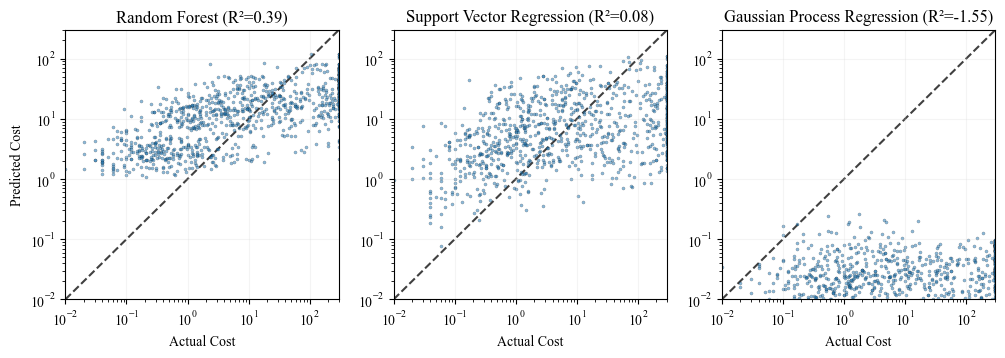

In [220]:
model_keys = list(models.keys())
n_models = len(model_keys)

fig, axs = plt.subplots(nrows=1, ncols=n_models, figsize=(n_models * 4, 3.5))

for i, model_key in enumerate(model_keys):
    ax = axs[i]
    result = models[model_key]["result"]

    sc = ax.scatter(
        np.exp(result["y_test"]) - 1,
        np.exp(result["y_pred"]) - 1,
        alpha=0.5,
        edgecolors="k",
        lw=0.2,
        s=5,
    )
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlim(0.01, 300)
    ax.set_ylim(0.01, 300)
    ax.plot([0.01, 300], [0.01, 300], "k--", alpha=0.75, zorder=0)

    ax.set_xlabel("Actual Cost")
    ax.set_title(f'{models[model_key]["name"]} (R²={result["r2"]:.2f})')

axs[0].set_ylabel("Predicted Cost")
plt.subplots_adjust(wspace=0.2)
plt.show()

## N

In [267]:
models = {
    "rf": {
        "model": RandomForestRegressor(**rf_incumbent, n_jobs=-1, random_state=0),
        "name": "Random Forest"
    },
    "svr": {
        "model": SVR(**svr_incumbent),
        "name": "Support Vector Regression"
    },
    "gpr": {
        "model": GPRWithRBF(**gpr_incumbent),
        "name": "Gaussian Process Regression"
    },
}

In [268]:
records = []
for model_key, model_info in models.items():
    for solver_number in [5, 10, 15, 25, 35, 55, 80, 125, 185, 275, 415, 625, 930]:
        print(model_key, solver_number)
        result = evaluate_model_with_cross_validation(
            df,
            model_info["model"],
            n=5,
            instance_number=10,
            solver_number=solver_number,
            random_state=0,
        )
        records.append({
            "model_key": model_key,
            "model_name": model_info["name"],
            "solver_number": solver_number,
            "rmse": result["rmse"],
            "cc": result["cc"],
            "r2": result["r2"],
        })

rf 5
rf 10
rf 15
rf 25
rf 35
rf 55
rf 80
rf 125
rf 185
rf 275
rf 415
rf 625
rf 930
svr 5
svr 10
svr 15
svr 25
svr 35
svr 55
svr 80
svr 125
svr 185
svr 275
svr 415
svr 625
svr 930
gpr 5
gpr 10
gpr 15
gpr 25
gpr 35
gpr 55
gpr 80
gpr 125
gpr 185
gpr 275
gpr 415
gpr 625
gpr 930


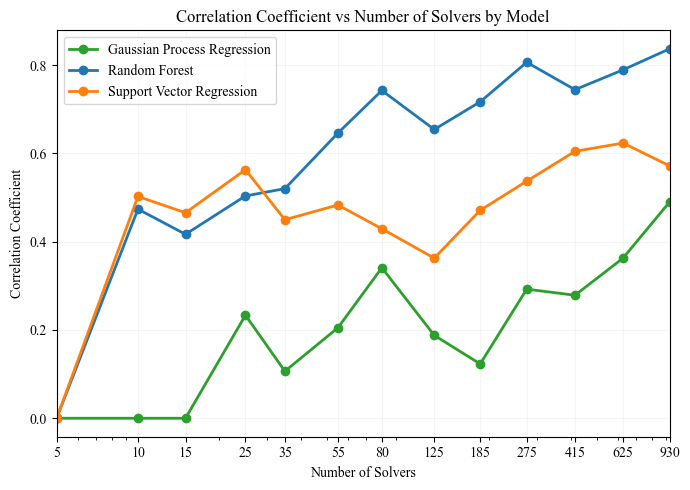

In [271]:
fig, ax = plt.subplots(figsize=(7, 5))

df_plot = pd.DataFrame(records).fillna(0)

unique_models = df_plot['model_name'].unique()
colors = plt.cm.tab10(range(len(unique_models))) 
color_map = {model: colors[i] for i, model in enumerate(unique_models)}

for model_name, group in df_plot.groupby('model_name'):
    group = group.sort_values('solver_number')
    plt.plot(
        group['solver_number'], 
        group['cc'], 
        'o-', 
        label=model_name,
        color=color_map[model_name],
        linewidth=2,
        markersize=6
    )

plt.xscale('log')
plt.xlabel('Number of Solvers')
plt.ylabel('Correlation Coefficient')
plt.legend(loc='best', frameon=True)
plt.xticks(df_plot['solver_number'].unique(), df_plot['solver_number'].unique())
plt.title('Correlation Coefficient vs Number of Solvers by Model')
plt.tight_layout()
plt.show()